# OptML Project : Image Denoising Using a Chambolle Scheme with Isotropic and Anisotropic Total Variations

This notebook contains the main code that produces the different results present in our report. The different sections follow the report, with additional results (less important) results not included in the latter.

### Imports

Please refer to the ReadME file for the necessary library installations.

In [1]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal
import scipy
from skimage.metrics import structural_similarity as compute_ssim
import pandas as pd
import random 
import pandas as pd
import pooch
import cv2 

## Important definitions for the correct implementation of Chambolle's Dual Scheme.

### Discrete Gradient operators

We first define the discrete gradient operator $D$ and its adjoint $D^*$. Their code implementation was taken from `ForwardBackwardDual.ipynb`. As it is stacked in one line only, please refer to `D_explanations.ipynb` where we detailed the exact operations performed by $D$ and $D^*$, if needed.

In [2]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [3]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

### Our addition of the anisotropic Total Variation (TV) term

As stated in the report, we regularize the strongly convex primal problem by adding the corresponding anisotropic TV term  (the number between parentheses correspond to the ones on the PDF report) :
$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= f(x)+ g(Dx) + \alpha \lVert Dx \rVert_{1} =\frac{1}{2}\|x-y\|^2+\lambda\|Dx\|_{1,2} + \alpha \lVert Dx \rVert_{1} \ (9)$$ 


Which is equivalent to

$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= \frac{1}{2}\|x-y\|^2+ h(Dx)$$

Where :

$$ h(x) = f(x) + g(x), \text{and} $$
$$ f(x) = \lambda\|x\|_{1,2}  $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

Therefore, we have to adapt the proximal operator for $h$, knowing that :

$$ x = \text{prox}_{\gamma h^*}(x) + \gamma \text{prox}_{h/\gamma}(x/\gamma) $$

Moreover, we know that

$$ \text{prox}_{\gamma h}(x) =  \text{prox}_{\gamma f}(x) \circ \text{prox}_{\gamma g}(x) \ (12) $$

Thus yielding


$$\begin{aligned}

\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) \\
\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{f / \gamma}(\text{prox}_{g / \gamma}(u/\gamma) ) \ (15)
\end{aligned}$$


Regarding $\text{prox}_{f/\gamma}(u/\gamma)$, we know that for $f(x) =  \lambda \ \lVert x \rVert_{1,2} $, we have 

$$\big(\text{prox}_{\gamma f^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$ 

Using the Moreau identity once again, and in the context of our newly defined problem, we can write 

$$

 \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \big(\text{prox}_{\gamma f^*}(u)\big) 
$$


$$
\Rightarrow \text{prox}_{f/\gamma}(u/\gamma) = \frac{u - \big(\text{prox}_{\gamma f^*}(u)\big)}{\gamma} 
$$

Knowing that $\big(\text{prox}_{\gamma f^*}(u)\big)$ is implemented as `prox_f_conj` below, we adapt our implementation of $\text{prox}_{f/\gamma}(u)$ (Note that we use $\text{prox}_{f^*}(u)$ here as we have a closed form, easily usable here) :


In [4]:
def prox_f_conj (u, Lambda) :
    """
    The Dual proximal operator of the anisotropic term, as defined in ForwardBackwardDual.ipynb. Returns the operator, 
    applied to the 'u' variable.

    Parameters 
    ----------
    u : The 3D array on which the operator should be applied,
    Lambda : The regularization coefficient for the anisotropic TV term.

    Returns 
    ---------
    The resulting ndarray from the application of the operator.
    
    """
    if Lambda == 0:
        return u 
    else:
        return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/(Lambda),1),(1,1,2)) # soft-thresholding


In [5]:
def proximal_L12_operator(u,gamma,Lambda) : 
    """
    Applies the proximal operator of the L21 norm, using the Dual proximal operator of the latter.

    Parameters 
    ----------
    u : The 3D array on which the operator should be applied,
    Lambda : The regularization coefficient for the anisotropic TV term.

    Returns 
    ---------
    The resulting ndarray from the application of the operator.
    
    """

    return( (u - gamma*prox_f_conj(u/gamma,Lambda)))

For the proximal operator of $g(x) =  \alpha \ \lVert x \rVert_{1} $, we can implement its scaled operator as :



In [6]:
def proximal_operator_L1(u, alpha,gamma):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to u, scaled by 1/gamma, then reshape the result to what we need
        prox_result = L1.prox(u,gamma).reshape(u.shape)
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

We can then add both into the proximal operator of $h$ :

In [7]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    gamma : The proximal scaling gamma term (float)
    alpha : Constant that multiplies the Anisotropic term, controlling its regularization strength. (float)
    Lambda : Constant that multiplies the Isotropic term, controlling its regularization strength. (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    redef_u = u + gamma * D(x)
    prox_lasso = proximal_operator_L1(redef_u/gamma, alpha, 1/gamma)
    prox_tv = proximal_L12_operator(prox_lasso, 1/gamma, Lambda)
    proximal_composition = gamma * prox_tv
    return redef_u - proximal_composition

#### The original Chambolle algorithm

In the original implementation of the Chambolle algorithm the anisotropic term doesn't appear and the implementation is therefore much simpler.

This code snippet was taken from `background-notebooks/ForwardBackwardDual.ipynb`.

In [8]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter) 

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of
    #  noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


#### Implementation of the revised algorithm

We then implement this newly defined proximal operator into Chambolle's algorithm. As previously explained, the implementation stays the same, besides the computation of $u^{(k+1)}$, which is now defined as our composition of operators.

In [9]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter) 

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) + alpha * np.sum(np.abs(D(x)))
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


Note that for our new implementation, $E_d$ is not practically computable, due to the nature of our newly defined problem and $h^{*}$ unknown form. We let it, in our new implementation, as in the original implementation for simplicity throughout the notebook, but we will not use it and will focus on the primal energy, as maximization of $E_d$ coincidates with minimization of $E_p$ per definition of the primal-dual problem.

#### Metric for denoising evaluation

We will both use PSNR and SSIM as our evaluation metrics, and we define functions to compute them here.

In [10]:
def calculate_ssim(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    ssim_value = compute_ssim(img1, img2, data_range=max_value)
    return ssim_value

def calculate_psnr(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / np.sqrt(mse))

### First tests of the algorithms on the Ascent image.

To compare the original Chambolle algorithm with our revised version of the latter, we will first use the baseline Lena image from the `scipy.misc` package. This image represents two people walking up a wooden structure.

The code below generates the image and its noised version (Gaussian noise)

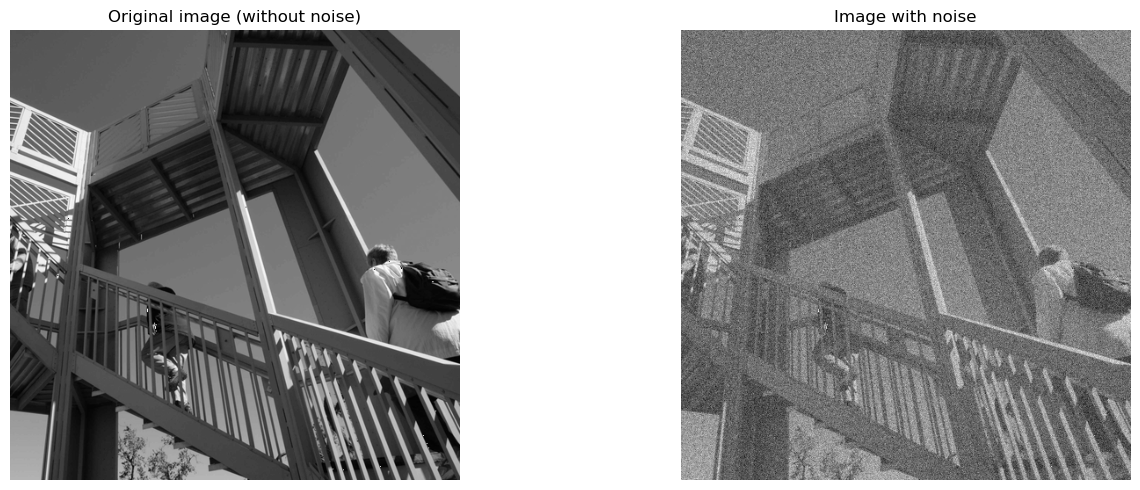

In [11]:
#Generating input, and adding the noise
xsharp = scipy.datasets.ascent()
xsharp = xsharp.astype(np.float32) 
(N1,N2) = np.shape(xsharp)
noiselevel = 35
noised_image = xsharp + noiselevel * np.random.randn(N1,N2)

#Plotting the original image and its noised version
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

We will now compare the two implementations at our disposal in the case of this image. Using the baseline parameters $\lambda = 25, \gamma= \frac{1.9}{8}$ and $\alpha = 20$ as a first try, we run :
- The original Chambolle once
- The revised Chambolle twice : Once with $\alpha=0$ and the second with $\alpha=10$. This is done to check that the case $\alpha=0$ indeed yields the same results as the original Chambolle.

In [12]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

original_denoised_image,original_ep_array,original_ed_array  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)
denoised_image_nolasso,alphazero_ep_array,alphazero_ed_array  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,alpha_ep_array,alpha_ed_array = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

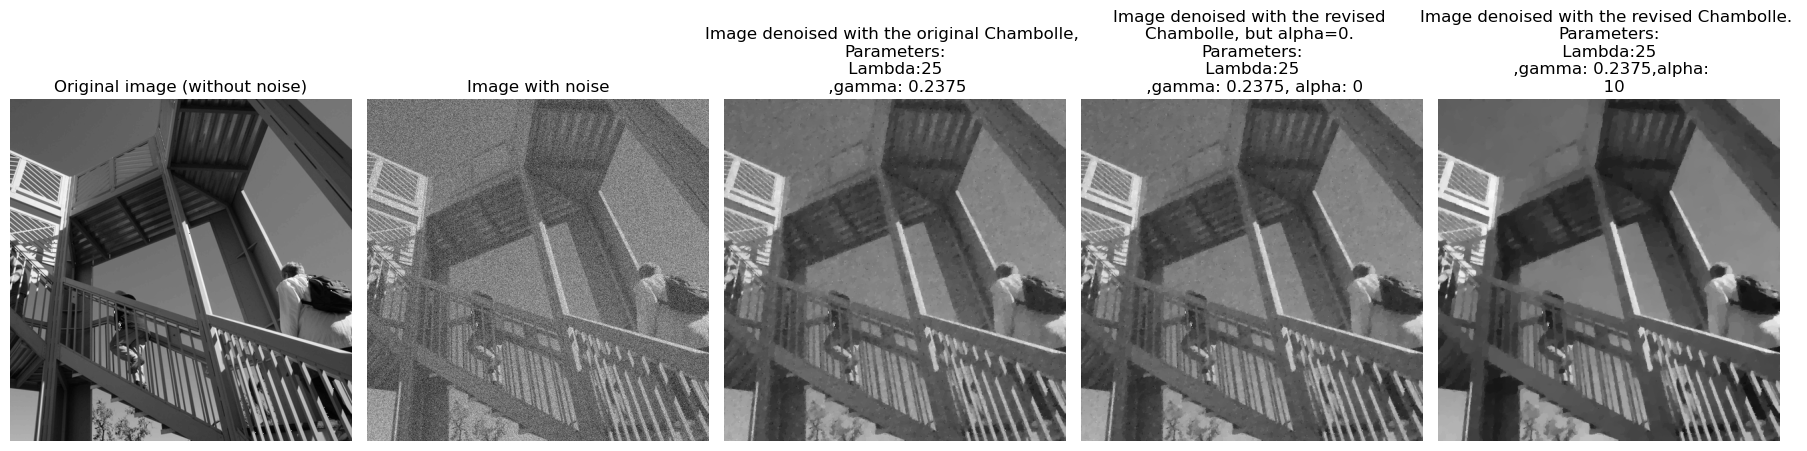

PSNR/SSIM of the noisy image:17.247926261739778 / 0.28152840197959
PSNR/SSIM for original Chambolle: 26.44508826725914 / 0.7465236433682504
PSNR/SSIM for revised version with alpha = 0 : 26.44508826725914 / 0.7465236433682504
PSNR/SSIM for revised version with alpha different from 0 : 25.954107522930975 / 0.7963128282412176


In [13]:
fig, axs = plt.subplots(1, 5, figsize=(18, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


print("PSNR/SSIM of the noisy image:" +  str(calculate_psnr(xsharp, noised_image)) + ' / ' + str(calculate_ssim(xsharp, noised_image)) )
print("PSNR/SSIM for original Chambolle:", str(calculate_psnr(xsharp, original_denoised_image)) + ' / ' + str(calculate_ssim(xsharp, original_denoised_image)))
print("PSNR/SSIM for revised version with alpha = 0 :", str(calculate_psnr(xsharp, denoised_image_nolasso)) + ' / ' + str(calculate_ssim(xsharp, denoised_image_nolasso)))
print("PSNR/SSIM for revised version with alpha different from 0 :", str(calculate_psnr(xsharp, denoised_image_lasso)) + ' / ' + str(calculate_ssim(xsharp, denoised_image_lasso)))


The images 3 & 4 (from left to right) above seem to indicate that our revised implementation of Chambolle's algorithm with $\alpha= 0$ and the original Chambolle lead to the same denoised image. Moreover, we can see that adding the $\alpha$ parameter and thus, the new term we added in our primal problem, have an impact on the denoising result. Namely, from what we can see here,  the image is a bit better denoised and thus a tiny bit more blurred, due to what seems like a smoothing of the different textures. 

##### Are the original Chambolle and revised Chambolle with $\alpha=0$ the same?

Keeping the investigation on the exact importance of the $\alpha$ parameter for later, let us first focus on comparing our $\alpha = 0$ setting to the original Chambolle. More specifically, let us take a look at the Primal and Dual energies resulting from the iterations :

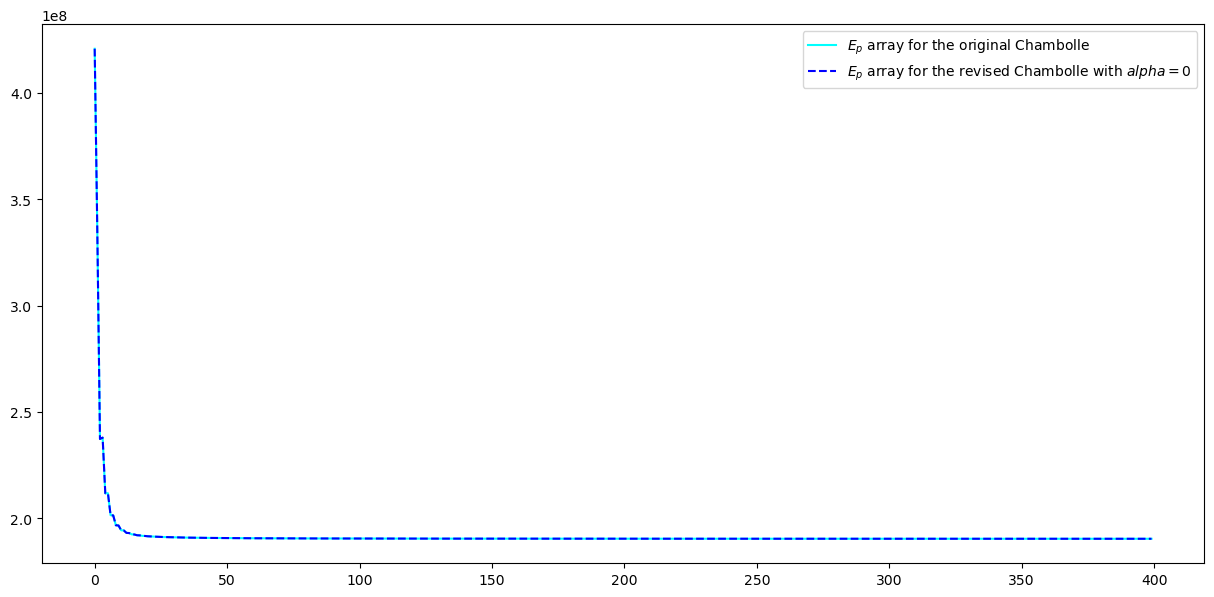

In [14]:
plt.figure(figsize=(15,7))

plt.plot(original_ep_array, color='cyan', label='$E_p$ array for the original Chambolle')

plt.plot(alphazero_ep_array, color='b', linestyle='--', label='$E_p$ array for the revised Chambolle with $alpha=0$')

plt.legend()

plt.show()

We indeed obtain the exact same steps throughout the iterations : the two methods are equal. Does this change anything with respect to the Signal To Noise Ratio (SNR)?

In [15]:
noisy_image_psnr = calculate_psnr(xsharp, noised_image)
original_chambolle_psnr = calculate_psnr(xsharp, original_denoised_image)
alphazero_psnr = calculate_psnr(xsharp, denoised_image_nolasso)

print("PSNR of the noisy image:", noisy_image_psnr)
print("PSNR for original Chambolle:", original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", alphazero_psnr)


PSNR of the noisy image: 17.247926261739778
PSNR for original Chambolle: 26.44508826725914
PSNR for revised version with alpha = 0 : 26.44508826725914


The images we obtain after denoising are the exact same : the PSNR is the same for 14 digits after the comma. Let's see if that is the case for different noise levels. We generate PSNR & SSIM values for both our new (with $\alpha$ = 0) implemententation, and for the original:

<div class="alert alert-block alert-info"> <b>NOTE</b> The cell takes approximately 10 minutes to run. </div>

In [16]:
#We define the different parameters and initialize empty lists
Lambda = 25 
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10
noise_levels = [5,10,15,25,35,50]
psnr_values_og = []
psnr_values_alphazero = []
ssim_values_og = []
ssim_values_alphazero = []

#For all of our noise levels, we generate the PSNR & SSIM for a fixed value of lambda
for noise_level in noise_levels:
    noised_img = xsharp + noise_level * np.random.randn(N1, N2)
    og_denoised, _, _ = original_chambolle_algorithm(noised_img, Lambda, gamma, nbiter)
    alphazero_denoised, _, _ = chambolle_algorithm(noised_img, Lambda, gamma, 0, nbiter)

    psnr_values_og.append(calculate_psnr(xsharp, og_denoised))
    psnr_values_alphazero.append(calculate_psnr(xsharp, alphazero_denoised))
    ssim_values_og.append(calculate_ssim(xsharp, og_denoised))
    ssim_values_alphazero.append(calculate_ssim(xsharp, alphazero_denoised))


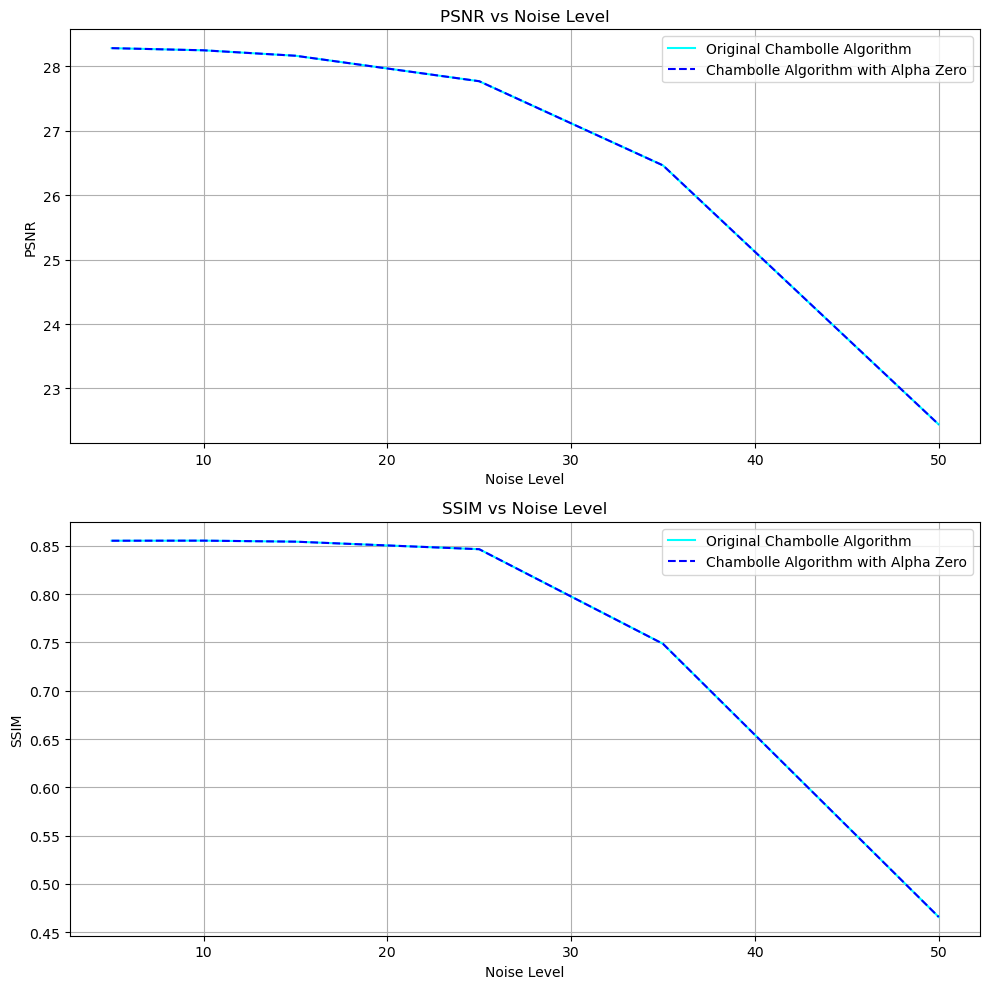

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(noise_levels, psnr_values_og, color='cyan', label='Original Chambolle Algorithm')
axs[0].plot(noise_levels, psnr_values_alphazero, color='b', linestyle='--', label='Chambolle Algorithm with Alpha Zero')
axs[0].set_xlabel('Noise Level')
axs[0].set_ylabel('PSNR')
axs[0].set_title('PSNR vs Noise Level')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(noise_levels, ssim_values_og, color='cyan', label='Original Chambolle Algorithm')
axs[1].plot(noise_levels, ssim_values_alphazero, color='b', linestyle='--', label='Chambolle Algorithm with Alpha Zero')
axs[1].set_xlabel('Noise Level')
axs[1].set_ylabel('SSIM')
axs[1].set_title('SSIM vs Noise Level')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

plt.show()

As can be expected, with fixed parameters $\alpha$ and $\lambda$, PSNR decreases with the noise level, but we can observe that the PSNR or the original Chambolle algorithm and of the revised version, with $\alpha = 0$, are the exact same.

### Investigating the effect of the addition of the anisotropic term (to our objective primal function) to the denoising problem.

Now that we've confirmed the implementation of the revised version of the algorithm, let us tackle the effect of the anisotropic term.
In the case of dummy values for our different parameters, on the Lena image, we saw a slight blur/smoothing induced by the introduction of the latter. 

With  $\alpha = 0$, i.e original Chambolle, we can see that the denoising is already improving sensitively the PSNR from the noised image. What about with $\alpha = 10$ (the parameter set earlier when generating the images ?)

In [18]:
alpha_psnr = calculate_psnr(xsharp, denoised_image_lasso)

print("PSNR/SSIM of the revised version with \u03B1 = 10: " +  str(calculate_psnr(xsharp, denoised_image_lasso)) + ' / ' + str(calculate_ssim(xsharp, denoised_image_lasso)) )

PSNR/SSIM of the revised version with α = 10: 25.954107522930975 / 0.7963128282412176


SSIM confirms what can be seen in the image : improves a bit the denoising, increasing by ~0.5 compared to the setup where alpha is 0. The original Chambolle seems to perform better than our newly revised algorithm in this specific dummy setup. 

This can lead to the hypothesis that, original Chambolle is 'enough' for the image generated and its level of noise. We can thus ask ourselves what happens when the image is noisier than what it is now ?

In [19]:
new_noiselevel = 45
alpha= 10
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 200

noisier_image = xsharp + new_noiselevel * np.random.randn(N1,N2)

original_noisier_denoised_image,_,_  = original_chambolle_algorithm(noisier_image,Lambda,gamma,nbiter)
denoised_noisier_image_nolasso,_,_  = chambolle_algorithm(noisier_image,Lambda,gamma,0,nbiter)
denoised_noisier_image_lasso,_,_ = chambolle_algorithm(noisier_image,Lambda,gamma,20,nbiter)

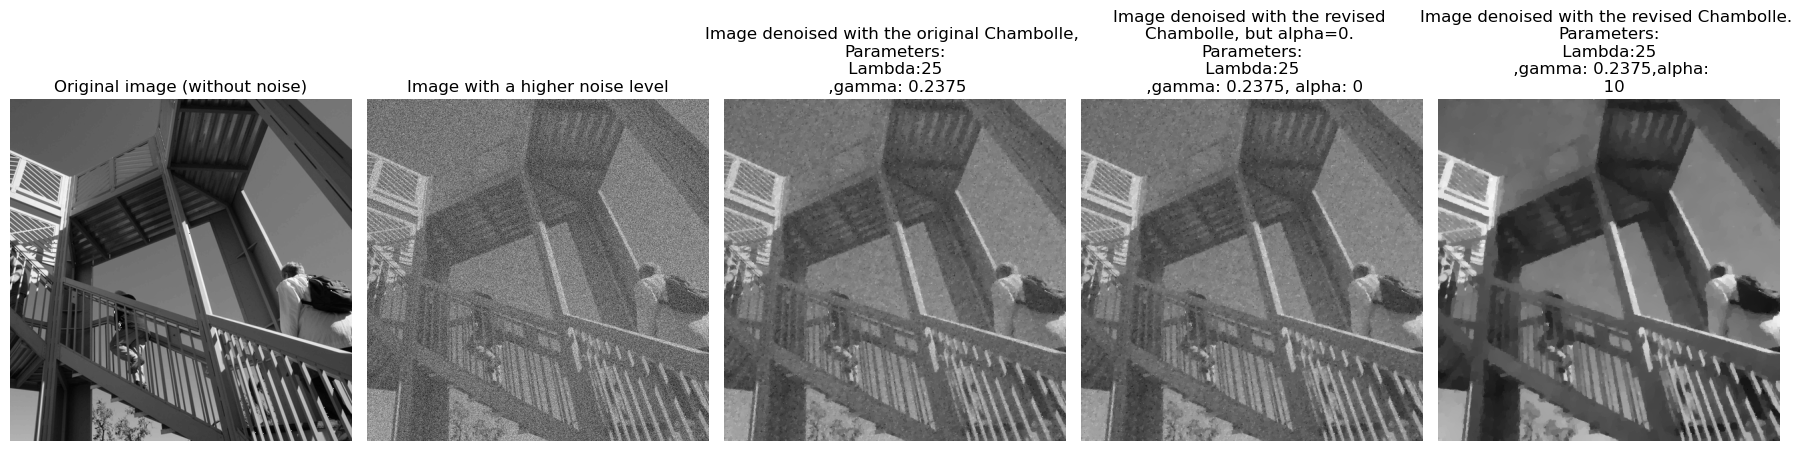

PSNR of the noisy image: 15.067171857264093
PSNR for original Chambolle: 23.86225106647249
PSNR for revised version with alpha = 0 : 23.86225106647249
PSNR of the image denoised with the revised Chambolle and alpha = 10: 24.792348540331773


In [20]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))

axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noisier_image, cmap='gray')
axs[1].set_title('Image with a higher noise level')

axs[2].imshow(original_noisier_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_noisier_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_noisier_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

noisier_image_psnr = calculate_psnr(xsharp, noisier_image)
noisier_original_chambolle_psnr = calculate_psnr(xsharp, original_noisier_denoised_image)
noisier_alphazero_psnr = calculate_psnr(xsharp, denoised_noisier_image_nolasso)
noisier_alpha_psnr = calculate_psnr(xsharp, denoised_noisier_image_lasso)

print("PSNR of the noisy image:", noisier_image_psnr)
print("PSNR for original Chambolle:", noisier_original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", noisier_alphazero_psnr)
print("PSNR of the image denoised with the revised Chambolle and alpha = 10:", noisier_alpha_psnr)

Interesting result : The PSNR is higher with $\alpha = 10$ compared to the other denoised images, the 'grain' effect coming from the noise seems to be diminished. On its own, it does not mean much tho : it could very well be that setting $\lambda$ is just not 'high enough' for such a noise, and that setting it to a higher value may induce $\alpha$ to become irrelevant.

To further investigate the issue, let us observe the behaviour of the PSNR with varying values of $\lambda$ and $\alpha$, in order to understand better the relationship and the potential trade-off between these two parameters.

<div class="alert alert-block alert-info"> <b>NOTE</b> The cell takes approximately 30 minutes to run. </div>

In [21]:
#We generate a grid of parameters for which we want to investigate
alphas = np.linspace(10, 100, 10) 
lambdas = np.linspace(10, 100, 10)  

#Creating empty arrays to store PSNR and SSIM values
psnr_values = np.zeros((len(alphas), len(lambdas)))
ssim_values = np.zeros((len(alphas), len(lambdas)))

#Filling the empty arrays
for i, alpha in enumerate(alphas):
    for j, Lambda in enumerate(lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisier_image, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(xsharp, denoised_image_)
        psnr_values[i, j] = psnr
        ssim = calculate_ssim(xsharp, denoised_image_)
        ssim_values[i, j] = ssim


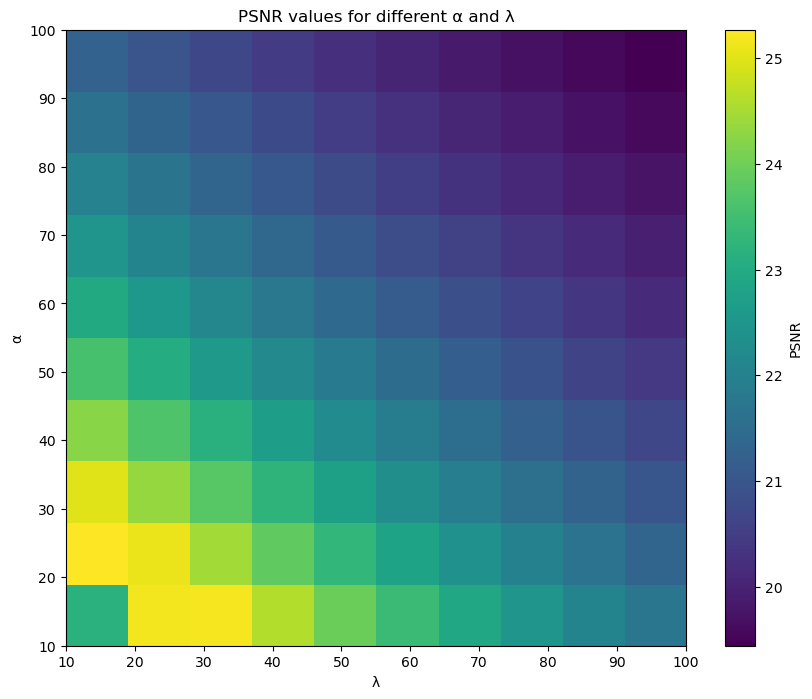

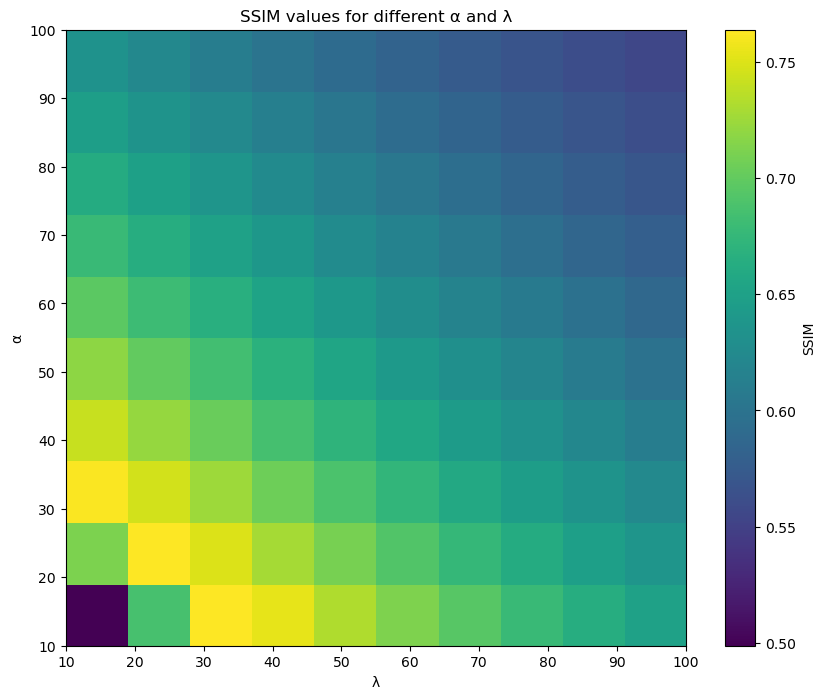

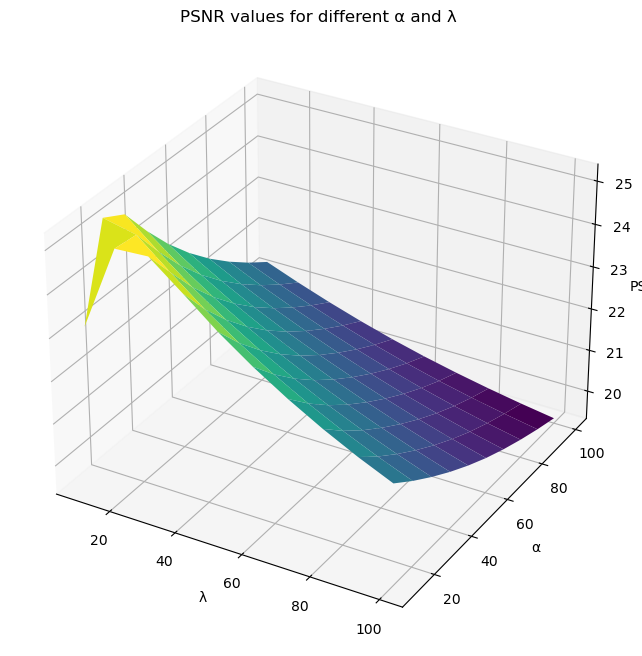

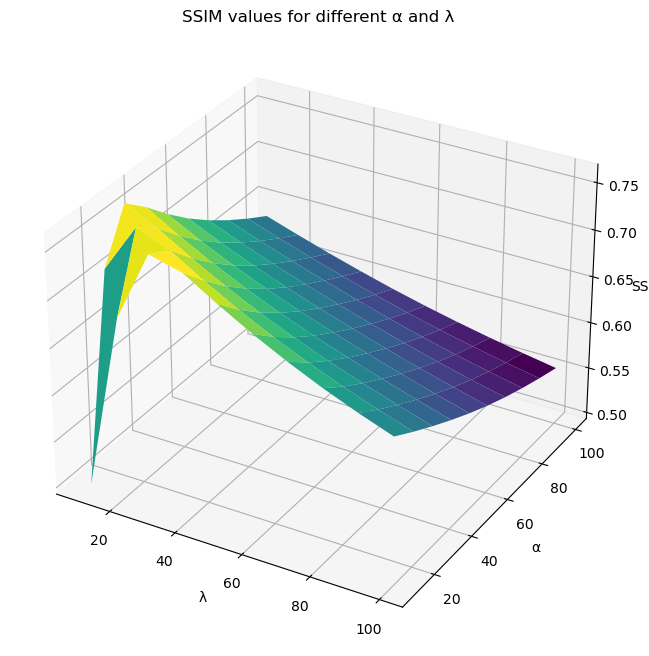

In [22]:
lambdas = np.sort(lambdas)
alphas = np.sort(alphas)

# Plotting the resulting heatmap for PSNR
plt.figure(figsize=(10, 8))
plt.imshow(psnr_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('\u03BB')
plt.ylabel('\u03B1')
plt.title('PSNR values for different \u03B1 and \u03BB')
plt.show()

# Plotting the resulting heatmap for SSIM
plt.figure(figsize=(10, 8))
plt.imshow(ssim_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='SSIM')
plt.xlabel('\u03BB')
plt.ylabel('\u03B1')
plt.title('SSIM values for different \u03B1 and \u03BB')
plt.show()

# Same plot for PSNR , but in 3D for a potential better visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(lambdas, alphas)
ax.plot_surface(L, A, psnr_values, cmap='viridis')
ax.set_xlabel('\u03BB')
ax.set_ylabel('\u03B1')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different \u03B1 and \u03BB')
plt.show()

# Same plot for SSIM , but in 3D for a potential better visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L, A, ssim_values, cmap='viridis')
ax.set_xlabel('\u03BB')
ax.set_ylabel('\u03B1')
ax.set_zlabel('SSIM')
ax.set_title('SSIM values for different \u03B1 and \u03BB')
plt.show()


Looking at the obtained heatmap(s), higher values of the parameters are not interesting to consider and yield worse PSNR values (for that specific level of noise, that is). Let us perform the same thing, but only considering 'lower' values of our parameters. 

<div class="alert alert-block alert-info"> <b>NOTE</b> The cell takes approximately 80 minutes to run. </div>

In [23]:
new_alphas = np.linspace(1, 70, 15) 
new_lambdas = np.linspace(1, 70, 15)  

new_psnr_values = np.zeros((len(new_alphas), len(new_lambdas)))
new_ssim_values = np.zeros((len(new_alphas), len(new_lambdas)))

for i, alpha in enumerate(new_alphas):
    for j, Lambda in enumerate(new_lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisier_image, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(xsharp, denoised_image_)
        new_psnr_values[i, j] = psnr
        ssim = calculate_ssim(xsharp, denoised_image_)
        new_ssim_values[i, j] = ssim

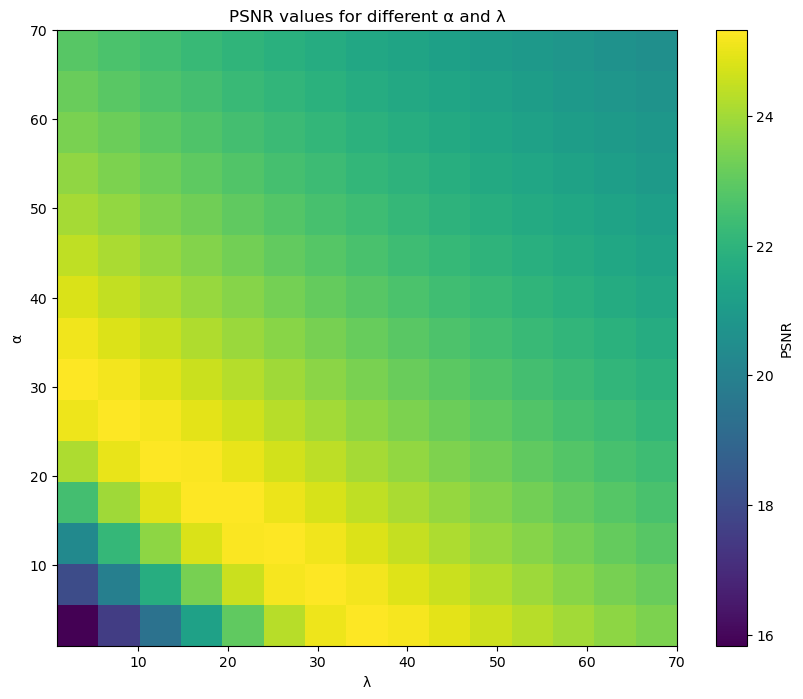

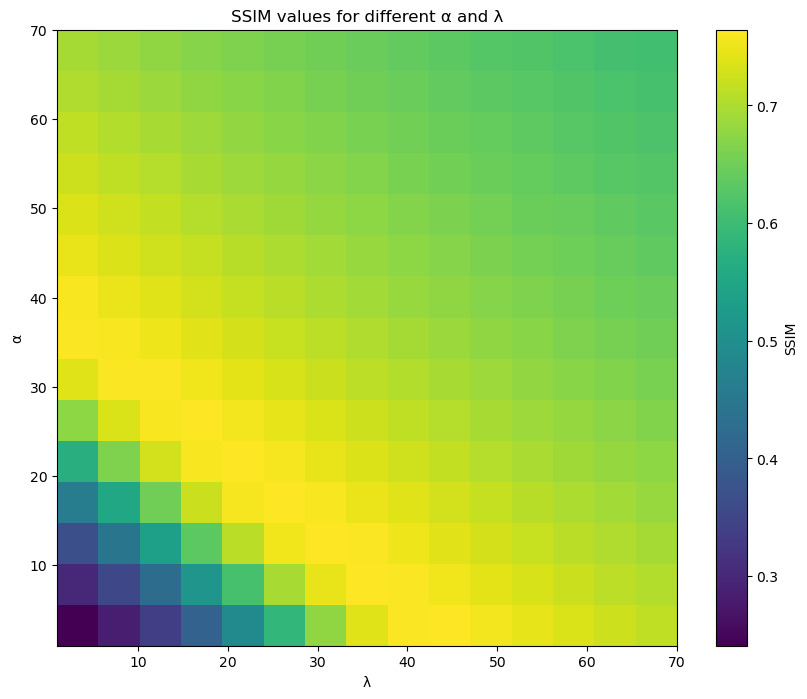

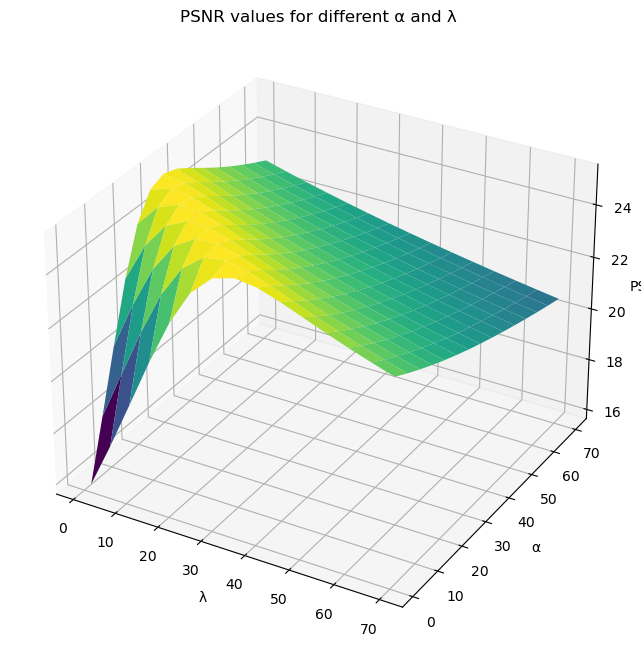

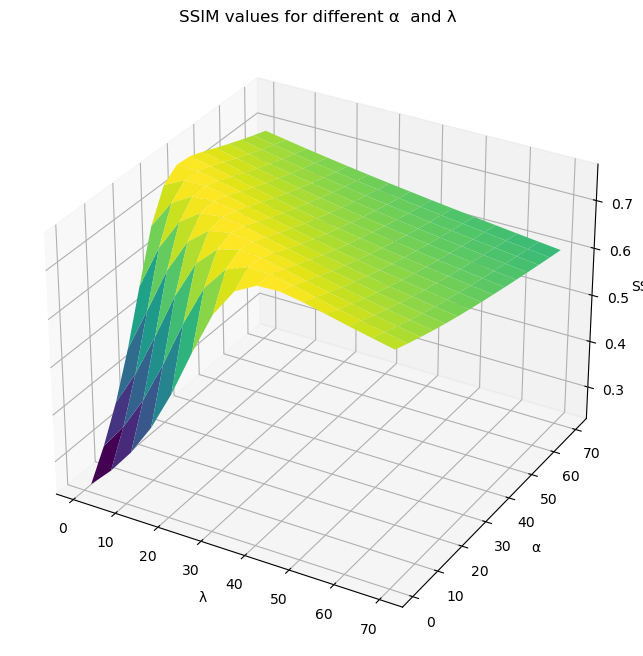

In [24]:
new_alphas = np.sort(new_alphas)
new_lambdas = np.sort(new_lambdas)

# Plot heatmap for PSNR
plt.figure(figsize=(10, 8))
plt.imshow(new_psnr_values, cmap='viridis', aspect='auto', extent=[new_lambdas[0], new_lambdas[-1], new_alphas[0], new_alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('\u03BB')
plt.ylabel('\u03B1')
plt.title('PSNR values for different \u03B1 and \u03BB')
plt.show()

# Plot heatmap for SSIM
plt.figure(figsize=(10, 8))
plt.imshow(new_ssim_values, cmap='viridis', aspect='auto', extent=[new_lambdas[0], new_lambdas[-1], new_alphas[0], new_alphas[-1]], origin='lower')
plt.colorbar(label='SSIM')
plt.xlabel('\u03BB')
plt.ylabel('\u03B1')
plt.title('SSIM values for different \u03B1 and \u03BB')
plt.show()

# 3D plot of PSNR values
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(new_lambdas, new_alphas)
ax.plot_surface(L, A, new_psnr_values, cmap='viridis')
ax.set_xlabel('\u03BB')
ax.set_ylabel('\u03B1')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different \u03B1 and \u03BB')
plt.show()

# 3D plot of SSIM values
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L, A, new_ssim_values, cmap='viridis')
ax.set_xlabel('\u03BB')
ax.set_ylabel('\u03B1')
ax.set_zlabel('SSIM')
ax.set_title('SSIM values for different \u03B1  and \u03BB')
plt.show()

Seems to be a "range" of parameters that are optimal : From that heatmap only, it's hard to evaluate the exact effect for $\alpha$ / say if it has an effect at all. It seems like we could set the sum of $\alpha$ and $\lambda$ a certain interval, whatever the individual values are, to get a decent result. 

Moreover, we can observe that these values are not the same for optimal PSNR and SSIM : the shape is the same, but we need higher $\alpha$ and $\lambda$ for what seem like optimal values of SSIM than for PSNR.

Let us therefore see what they give in terms of Primal Energy values, but first :

Parenthesis : Study of $\lambda \approx 0$, with fixed $\alpha$. The definition of the proximal operator for our isotropic term, as defined in the theory, contains a division by $\lambda$, making it somewhat of a 'forbidden' value. We therefore see what happens when $\lambda \rightarrow 0$ to see if we can make an approximation or not.

<div class="alert alert-block alert-info"> <b>NOTE</b> The cell takes approximately 7 minutes to run. </div>

In [25]:
lambdas = [1e-25,1e-20,1e-15,1e-10,1e-5,1e-3,1e-2,1e-1,1]
fixed_alpha = 45
psnrs = []

for lambda_ in lambdas :
    with_fixed_alpha,_,_ = chambolle_algorithm(noisier_image,lambda_,gamma,fixed_alpha,100)
    curr_psnr = calculate_psnr(xsharp, with_fixed_alpha)
    psnrs.append(curr_psnr)


In [26]:
df = pd.DataFrame({'Lambda': lambdas, 'PSNR': psnrs})

display(df)

Lambda       PSNR
0  1.000000e-25  24.503403
1  1.000000e-20  24.503403
2  1.000000e-15  24.503403
3  1.000000e-10  24.503403
4  1.000000e-05  24.503401
5  1.000000e-03  24.503338
6  1.000000e-02  24.502764
7  1.000000e-01  24.497009
8  1.000000e+00  24.439623

When looking at very small values of $\lambda$, meaning that the isotropic term will be nearly inexistant, we obtain extremely similar values of the PSNR as $\lambda \rightarrow 0$.

Reasonable to assume, that setting $\lambda$ won't change the result by much, we can use this to approximate the result when $\lambda = 0$ 

(End of the parenthesis)

#### From the heatmap, for 'optimal' PSNR :

We take, from the heatmap, values that correspond to 'optimal' lambda and alpha values for the three cases :
- Contribution of both $\alpha$ and $\lambda$
- No $\lambda$,  $\alpha \neq 0$ : only the anisotropic term
- $\lambda \neq 0$, No $\alpha$ : only the isotropic term

In [27]:
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 200

both_alpha_lambda,both_ep_array,_  = chambolle_algorithm(noisier_image,20,gamma,18,nbiter)
high_alpha,high_alpha_ep_array,_  = chambolle_algorithm(noisier_image,1e-8,gamma,30,nbiter)
high_lambda,high_lambda_ep_array,_ = chambolle_algorithm(noisier_image,35,gamma,0,nbiter)

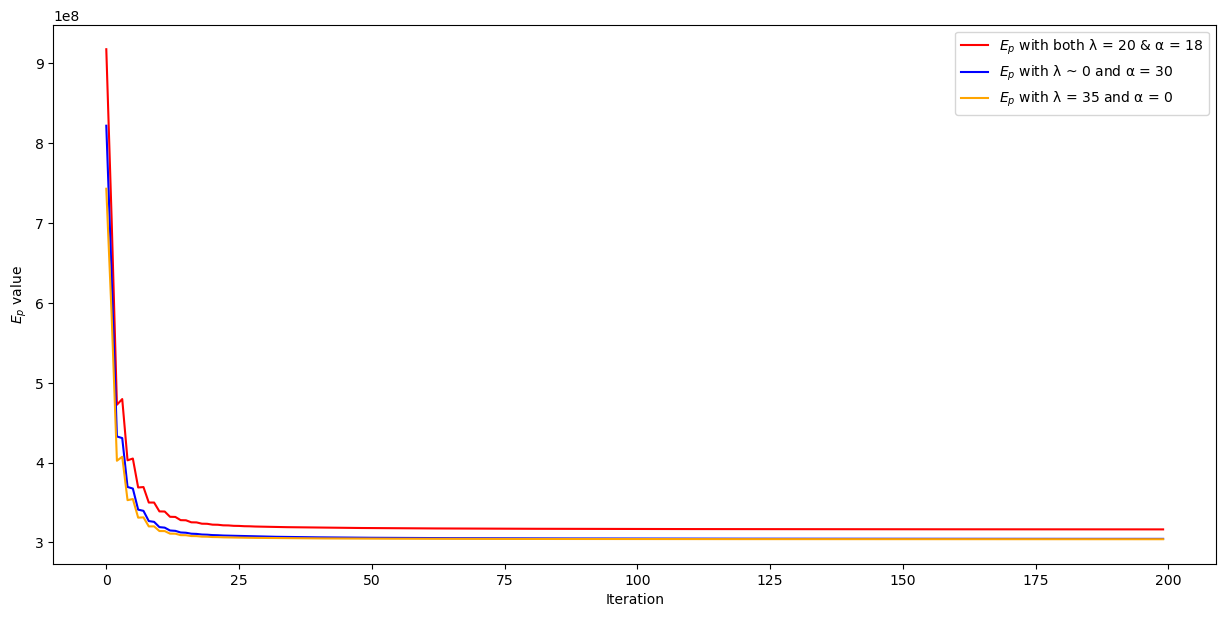

In [28]:
plt.figure(figsize=(15,7))

plt.plot(both_ep_array, color='red', label='$E_p$ with both \u03BB = 20 & \u03B1 = 18')
#plt.plot(-original_ed_array, color='orange', label='$-E_d$ array for the original Chambolle')

plt.plot(high_alpha_ep_array, color='b', linestyle='-', label='$E_p$ with \u03BB ~ 0 and \u03B1 = 30')
#plt.plot(-alphazero_ed_array, color='r', linestyle='--', label='$-E_d$ array for the revised Chambolle with $alpha=0$')

plt.plot(high_lambda_ep_array, color='orange', linestyle='-', label='$E_p$ with \u03BB = 35 and \u03B1 = 0')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$E_p$ value')

plt.show()

#### From the heatmap, for 'optimal' SSIM :

In [29]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 200
alpha = 10

ssim_both_alpha_lambda,ssim_both_ep_array,_  = chambolle_algorithm(noisier_image,25,gamma,20,nbiter)
ssim_high_alpha,ssim_high_alpha_ep_array,_  = chambolle_algorithm(noisier_image,1e-8,gamma,35,nbiter)
ssim_high_lambda,ssim_high_lambda_ep_array,_ = chambolle_algorithm(noisier_image,45,gamma,0,nbiter)

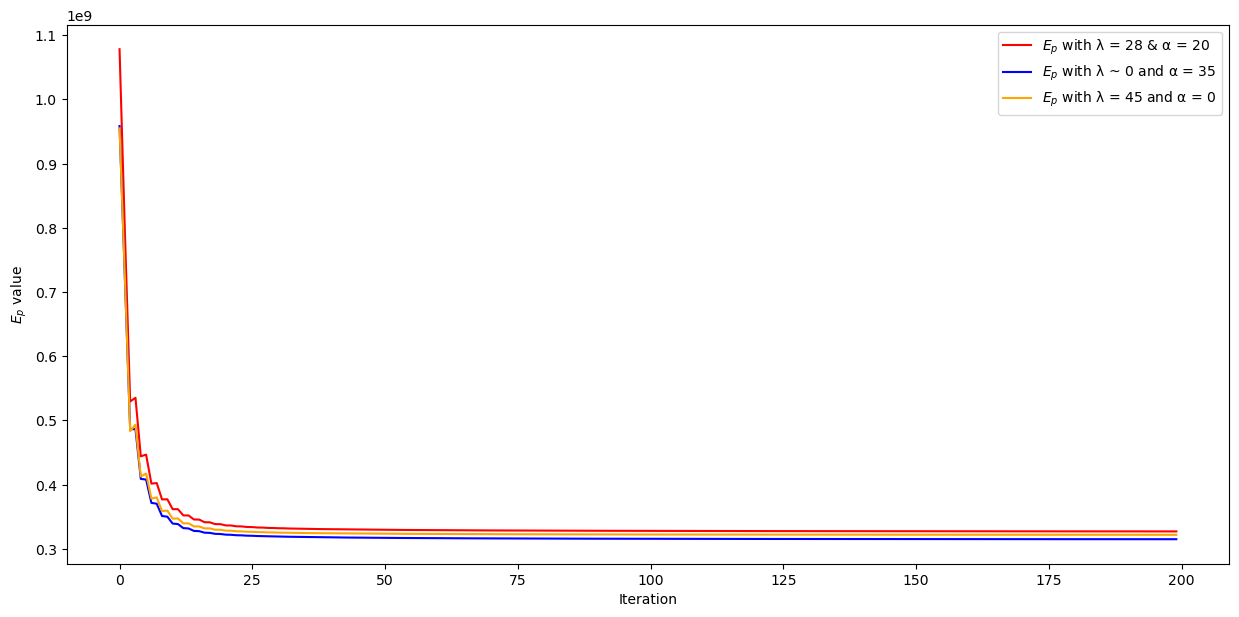

In [30]:
plt.figure(figsize=(15,7))

plt.plot(ssim_both_ep_array, color='red', label='$E_p$ with \u03BB = 28 & \u03B1 = 20')
#plt.plot(-original_ed_array, color='orange', label='$-E_d$ array for the original Chambolle')

plt.plot(ssim_high_alpha_ep_array, color='b', linestyle='-', label='$E_p$ with \u03BB ~ 0 and \u03B1 = 35')
#plt.plot(-alphazero_ed_array, color='r', linestyle='--', label='$-E_d$ array for the revised Chambolle with $alpha=0$')

plt.plot(ssim_high_lambda_ep_array, color='orange', linestyle='-', label='$E_p$ with \u03BB = 45 and \u03B1 = 0')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('$E_p$ value')

plt.show()

Let's look at what this yields for the images themselves :

##### For optimal PSNR :

In [31]:
both_alpha_lambda,_,_  = chambolle_algorithm(noisier_image,20,gamma,18,nbiter)
high_alpha,_,_  = chambolle_algorithm(noisier_image,1e-8,gamma,30,nbiter)
high_lambda,_,_ = chambolle_algorithm(noisier_image,35,gamma,0,nbiter)

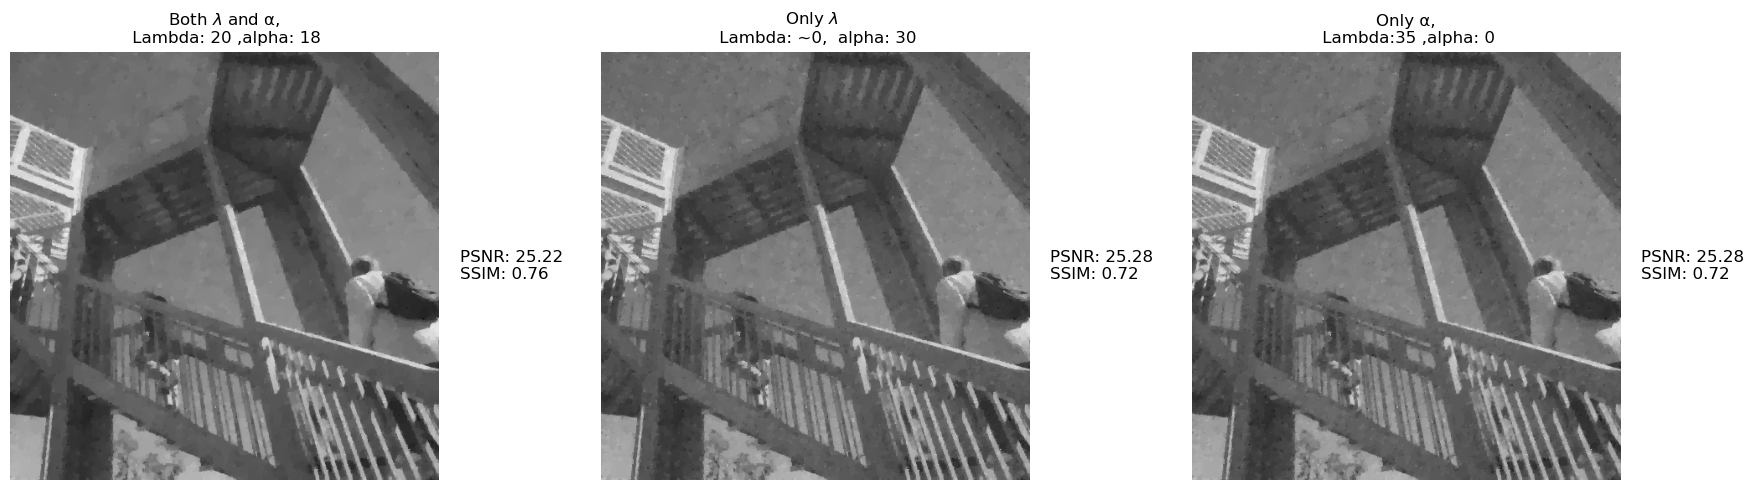

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

both_psnr = calculate_psnr(xsharp, both_alpha_lambda)
both_ssim = calculate_ssim(xsharp,both_alpha_lambda)

only_alpha_psnr = calculate_psnr(xsharp, high_alpha)
only_alpha_ssim = calculate_ssim(xsharp, high_alpha)

only_lambda_psnr = calculate_psnr(xsharp, high_lambda)
only_lambda_ssim = calculate_ssim(xsharp, high_lambda)


# Display images with titles
axs[0].imshow(both_alpha_lambda, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda: {20} ,alpha: {18}")
axs[0].text(1.05, 0.5, f"PSNR: {both_psnr:.2f}\nSSIM: {both_ssim:.2f}", transform=axs[0].transAxes, fontsize=12, verticalalignment='center')

axs[1].imshow(high_alpha, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda: ~{0},  alpha: {30}")
axs[1].text(1.05, 0.5, f"PSNR: {only_alpha_psnr:.2f}\nSSIM: {only_alpha_ssim:.2f}", transform=axs[1].transAxes, fontsize=12, verticalalignment='center')

axs[2].imshow(high_lambda, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{35} ,alpha: {0}")
axs[2].text(1.05, 0.5, f"PSNR: {only_lambda_psnr:.2f}\nSSIM: {only_lambda_ssim:.2f}", transform=axs[2].transAxes, fontsize=12, verticalalignment='center')

# Remove axis for all subplots
for ax in axs:
    ax.axis('off')

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.show()

##### For optimal SSIM :

In [33]:
both_alpha_lambda,_,_  = chambolle_algorithm(noisier_image,28,gamma,20,nbiter)
high_alpha,_,_  = chambolle_algorithm(noisier_image,1e-8,gamma,35,nbiter)
high_lambda,_,_ = chambolle_algorithm(noisier_image,45,gamma,0,nbiter)

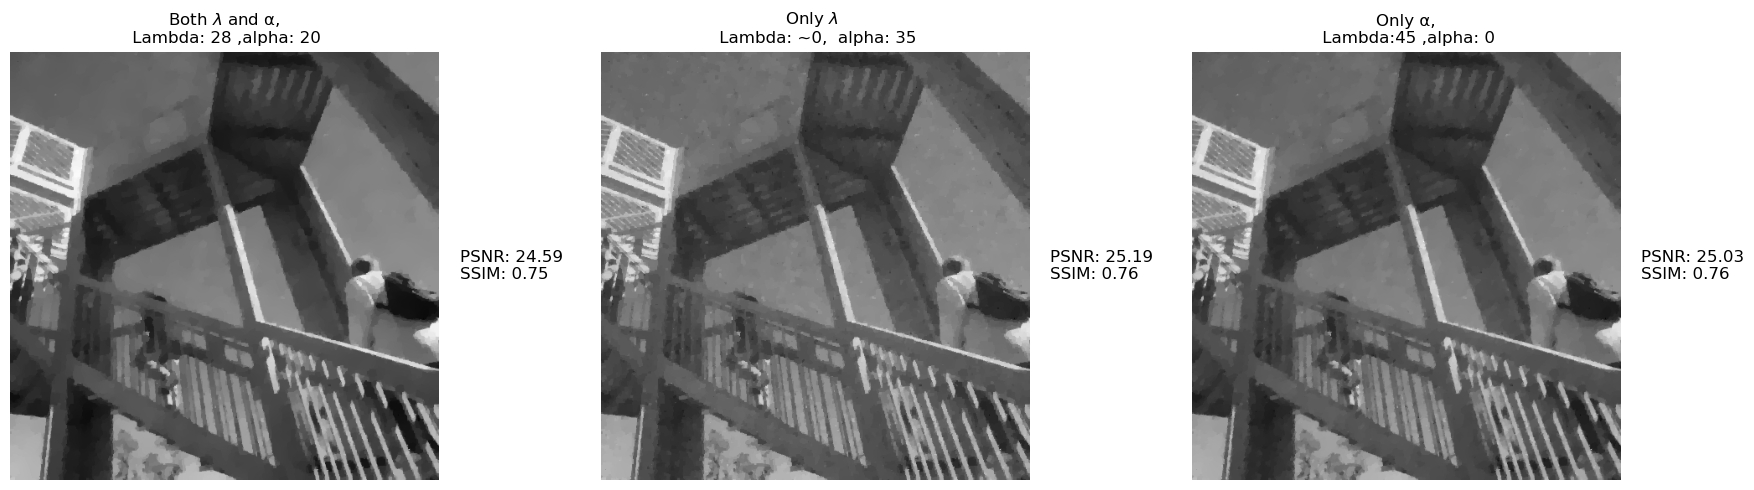

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

both_psnr = calculate_psnr(xsharp, both_alpha_lambda)
both_ssim = calculate_ssim(xsharp,both_alpha_lambda)

only_alpha_psnr = calculate_psnr(xsharp, high_alpha)
only_alpha_ssim = calculate_ssim(xsharp, high_alpha)

only_lambda_psnr = calculate_psnr(xsharp, high_lambda)
only_lambda_ssim = calculate_ssim(xsharp, high_lambda)


# Display images with titles
axs[0].imshow(both_alpha_lambda, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda: {28} ,alpha: {20}")
axs[0].text(1.05, 0.5, f"PSNR: {both_psnr:.2f}\nSSIM: {both_ssim:.2f}", transform=axs[0].transAxes, fontsize=12, verticalalignment='center')

axs[1].imshow(high_alpha, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda: ~{0},  alpha: {35}")
axs[1].text(1.05, 0.5, f"PSNR: {only_alpha_psnr:.2f}\nSSIM: {only_alpha_ssim:.2f}", transform=axs[1].transAxes, fontsize=12, verticalalignment='center')

axs[2].imshow(high_lambda, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda:{45} ,alpha: {0}")
axs[2].text(1.05, 0.5, f"PSNR: {only_lambda_psnr:.2f}\nSSIM: {only_lambda_ssim:.2f}", transform=axs[2].transAxes, fontsize=12, verticalalignment='center')

# Remove axis for all subplots
for ax in axs:
    ax.axis('off')

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.show()